adapted from <https://developmentalsystems.org/sensorimotor-lenia/>


In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

import torch

from pylib.auxlib._log_context_duration import log_context_duration
from pylib.auxlib._make_reproducible import make_reproducible
from pylib.difflenia._VideoWriter import VideoWriter
from pylib.difflenia._generate_observations import generate_observations

make_reproducible()
torch.set_default_tensor_type("torch.FloatTensor")


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-25T02:05:41.403485+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

torch: 2.0.1

Watermark: 2.4.3



In [4]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://osf.io/tqxhu/download' -O '/tmp/crea1.pickle'
!wget  'https://osf.io/tqfwk/download' -O '/tmp/crea2.pickle'
!wget  'https://osf.io/ba536/download' -O '/tmp/crea3.pickle'


--2025-03-25 02:05:41--  https://osf.io/tqxhu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1 [following]
--2025-03-25 02:05:41--  https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12214 (12K) [application/octet-stream]
Saving to: ‘/tmp/crea1.pickle’

/tmp/crea1.pickle   100%[===================>]  11.93K  --.-KB/s    in 0s      

2025-03-25 02:05:42 (84.5 MB/s) - ‘/tmp/crea1.pickle’ saved [12214/12214]

--2025-03-25 02:05:42--  https://osf.io/tqfwk/download
Resolving osf.io (osf.io)... 35.190

In [5]:
image_counter = it.count()
image_subdir = "out/dev-difflenia"
os.makedirs(image_subdir, exist_ok=True)


def make_gif_path():
    return f"{image_subdir}/image_{next(image_counter):04d}.gif"


In [6]:
def show_sample_observations(
    SX,
    SY,
    *,
    borders,
    device,
    mode,
    num_frames,
    crea_file="crea1.pickle",
    fps=30.0,
    logger=print,
    zoom=1,
):

    observations = generate_observations(
        SX=SX,
        SY=SY,
        borders=borders,
        crea_file=crea_file,
        device=device,
        mode=mode,
        num_frames=num_frames,
        zoom=zoom,
    )
    with log_context_duration("Creating video", logger=logger):
        with VideoWriter(make_gif_path(), fps) as vid:
            vid.add_observations(observations)
            vid.show()


In [7]:
SX, SY = 448, 448
borders = True
device = torch.device(["cpu", "cuda"][torch.cuda.is_available()])
logger = print
mode = "random"
num_frames = 1000


/home/runner/work/hstrat-agentless-concept/hstrat-agentless-concept/binder/pylib/difflenia/_LeniaStepFFTC.py:126: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.kernels[i] = kernel_FFT


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 19.636045455932617}
enter log_context_duration for Creating video


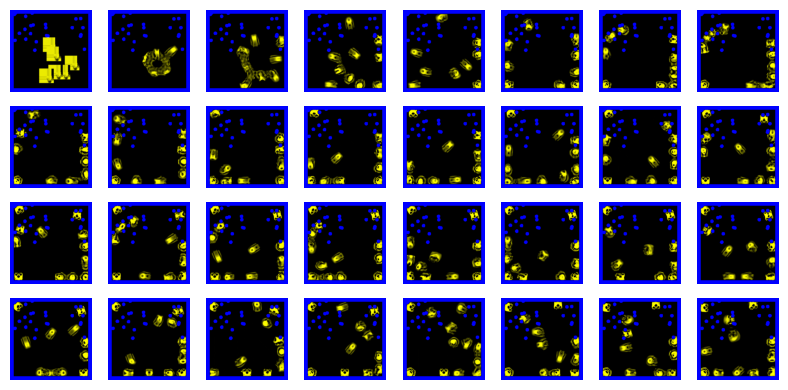

exit log_context_duration for Creating video
!!! {"Creating video": 29.75723934173584}
enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.65482234954834}
enter log_context_duration for Creating video


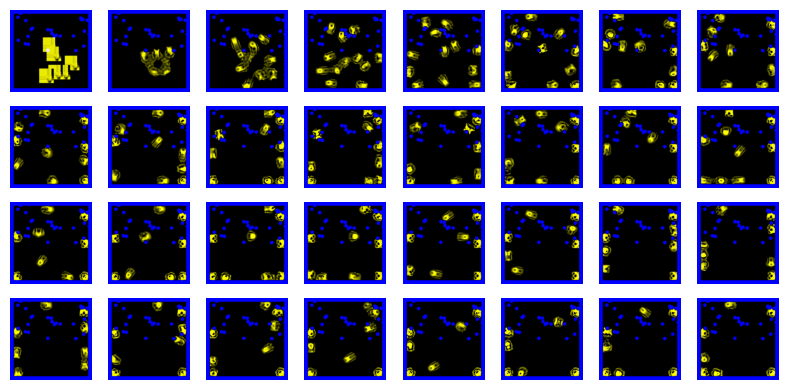

exit log_context_duration for Creating video
!!! {"Creating video": 28.39111876487732}


In [8]:
for i in range(2):
    show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea1.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )


enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 20.112313985824585}
enter log_context_duration for Creating video


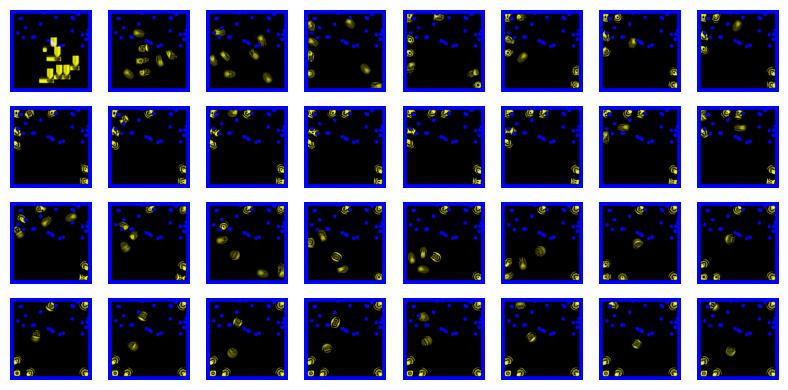

exit log_context_duration for Creating video
!!! {"Creating video": 27.79575753211975}
enter log_context_duration for Running Lenia
exit log_context_duration for Running Lenia
!!! {"Running Lenia": 21.210928678512573}
enter log_context_duration for Creating video


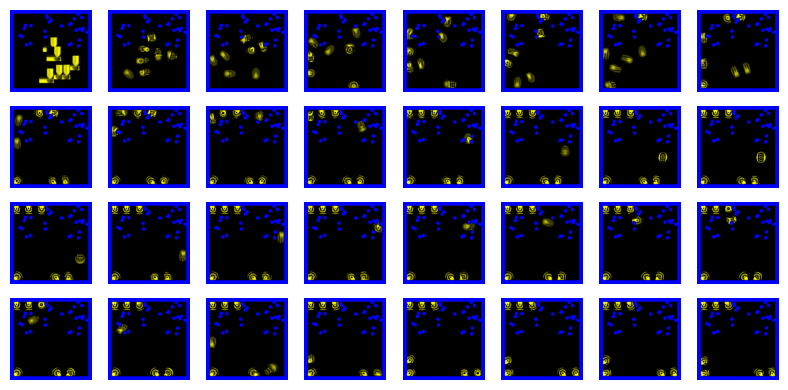

exit log_context_duration for Creating video
!!! {"Creating video": 27.0237979888916}


In [9]:
for i in range(2):
    show_sample_observations(
        SX,
        SY,
        borders=borders,
        crea_file="/tmp/crea2.pickle",
        device=device,
        logger=logger,
        mode=mode,
        num_frames=num_frames,
        zoom=1,
    )
